In [38]:
import boto3
import json 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.io.json
import seaborn as sns
pd.plotting.register_matplotlib_converters() 
%matplotlib inline

In [74]:
f = open("credentials.json")
credentials = json.load(f)

my_path = list(credentials.values())[0]
weather_key = list(credentials.values())[1]
aws_access_key = list(credentials.values())[2]
aws_secret_key = list(credentials.values())[3]
rds_host = list(credentials.values())[4]
rds_user = list(credentials.values())[5]
rds_password = list(credentials.values())[6]
rds_database = list(credentials.values())[7]
rds_charset = list(credentials.values())[8]
rds_port = list(credentials.values())[9]

your AWS account #


In [ ]:
# Import weather_history_bulk JSON file
f = open("weather_history_bulk.json")
weather_history_bulk = json.load(f)

In [2]:
# Convert JSON file to DataFrame
df = pd.json_normalize(weather_history_bulk)

In [3]:
# Data exploration
df.head

<bound method NDFrame.head of                  dt                         dt_iso  timezone  \
0         283996800  1979-01-01 00:00:00 +0000 UTC      3600   
1         284000400  1979-01-01 01:00:00 +0000 UTC      3600   
2         284004000  1979-01-01 02:00:00 +0000 UTC      3600   
3         284007600  1979-01-01 03:00:00 +0000 UTC      3600   
4         284011200  1979-01-01 04:00:00 +0000 UTC      3600   
...             ...                            ...       ...   
1972435  1704135600  2024-01-01 19:00:00 +0000 UTC    -28800   
1972436  1704139200  2024-01-01 20:00:00 +0000 UTC    -28800   
1972437  1704142800  2024-01-01 21:00:00 +0000 UTC    -28800   
1972438  1704146400  2024-01-01 22:00:00 +0000 UTC    -28800   
1972439  1704150000  2024-01-01 23:00:00 +0000 UTC    -28800   

                                                   weather  visibility  \
0        [{'id': 801, 'main': 'Clouds', 'description': ...     10000.0   
1        [{'id': 800, 'main': 'Clear', 'description':

In [4]:
df.shape 

(1972440, 23)

In [5]:
df.columns

Index(['dt', 'dt_iso', 'timezone', 'weather', 'visibility', 'lon', 'city_name',
       'lat', 'main.temp', 'main.temp_min', 'main.temp_max', 'main.feels_like',
       'main.pressure', 'main.humidity', 'main.dew_point', 'clouds.all',
       'wind.speed', 'wind.deg', 'snow.1h', 'wind.gust', 'rain.1h', 'rain.3h',
       'snow.3h'],
      dtype='object')

In [6]:
# Create seperate DataFrames by location
weather_history_berlin = df.loc[df['city_name'] == 'Berlin']
weather_history_tulum = df.loc[df['city_name'] == 'Tulum']
weather_history_corcovado = df.loc[df['city_name'] == 'Parque Nacional Corcovado']
weather_history_kotao = df.loc[df['city_name'] == 'Ko Tao']
weather_history_sandiego = df.loc[df['city_name'] == 'San Diego']

In [31]:
# Convert timestamp to date, add Y and YM column
pd.set_option('mode.chained_assignment', None)

def to_datetime(df, timestamp_column, date_column):
    df.loc[date_column] = pd.to_datetime(df.loc[:, timestamp_column], unit='s')
    df.drop(columns = [timestamp_column], inplace=True)
    df.loc['Y'] = int(df.loc[:, date_column].dt.year)

city_dfs = [weather_history_berlin, weather_history_tulum, weather_history_corcovado, weather_history_kotao, weather_history_sandiego]

for df in city_dfs:
    to_datetime(df, 'dt', 'date_column')
    

KeyError: 'dt'

In [22]:
weather_history_berlin.head

<bound method NDFrame.head of                                dt_iso  timezone  \
0       1979-01-01 00:00:00 +0000 UTC      3600   
1       1979-01-01 01:00:00 +0000 UTC      3600   
2       1979-01-01 02:00:00 +0000 UTC      3600   
3       1979-01-01 03:00:00 +0000 UTC      3600   
4       1979-01-01 04:00:00 +0000 UTC      3600   
...                               ...       ...   
394483  2024-01-01 19:00:00 +0000 UTC      3600   
394484  2024-01-01 20:00:00 +0000 UTC      3600   
394485  2024-01-01 21:00:00 +0000 UTC      3600   
394486  2024-01-01 22:00:00 +0000 UTC      3600   
394487  2024-01-01 23:00:00 +0000 UTC      3600   

                                                  weather  visibility  \
0       [{'id': 801, 'main': 'Clouds', 'description': ...     10000.0   
1       [{'id': 800, 'main': 'Clear', 'description': '...     10000.0   
2       [{'id': 800, 'main': 'Clear', 'description': '...     10000.0   
3       [{'id': 803, 'main': 'Clouds', 'description': ...     100

In [19]:
# Filter out data from 2024 for annual mean temperature (few data points)
def filter_out_year(df):
    return df[df['Y'] != '2024']

for i, df in enumerate(city_dfs):
    city_dfs[i] = filter_out_year(df)

# Replace NaN by 0
for i in city_dfs:
    i.fillna(0, inplace=True)

In [ ]:
# Save the filtered weather data for annual mean temperature in separate dataframe
filtered_weather_history_berlin = city_dfs[0]
filtered_weather_history_tulum = city_dfs[1]
filtered_weather_history_corcovado = city_dfs[2]
filtered_weather_history_kotao = city_dfs[3]
filtered_weather_history_sandiego = city_dfs[4]
    
# Transform the filtered dataframes to remove unneccessary data
selected_columns = ['city_name', 'date_column', 'main.temp', 'rain.1h', 'Y']

filtered_weather_history_berlin = filtered_weather_history_berlin[selected_columns]
filtered_weather_history_tulum = filtered_weather_history_tulum[selected_columns]
filtered_weather_history_corcovado = filtered_weather_history_corcovado[selected_columns]
filtered_weather_history_kotao = filtered_weather_history_kotao[selected_columns]
filtered_weather_history_sandiego = filtered_weather_history_sandiego[selected_columns]

In [32]:
# Transform the unfiltered dataframes to remove unneccessary data
selected_columns = ['city_name', 'date_column', 'main.temp', 'rain.1h', 'Y']

weather_history_berlin = weather_history_berlin[selected_columns]
weather_history_tulum = weather_history_tulum[selected_columns]
weather_history_corcovado = weather_history_corcovado[selected_columns]
weather_history_kotao = weather_history_kotao[selected_columns]
weather_history_sandiego = weather_history_sandiego[selected_columns]

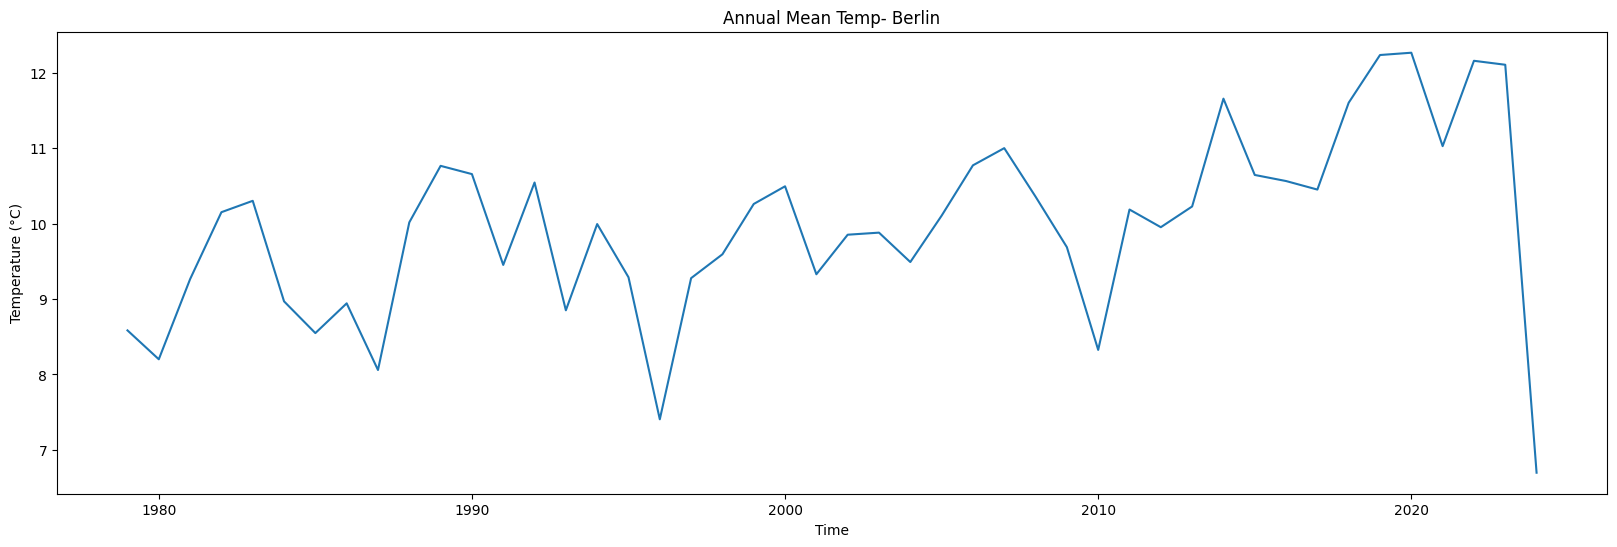

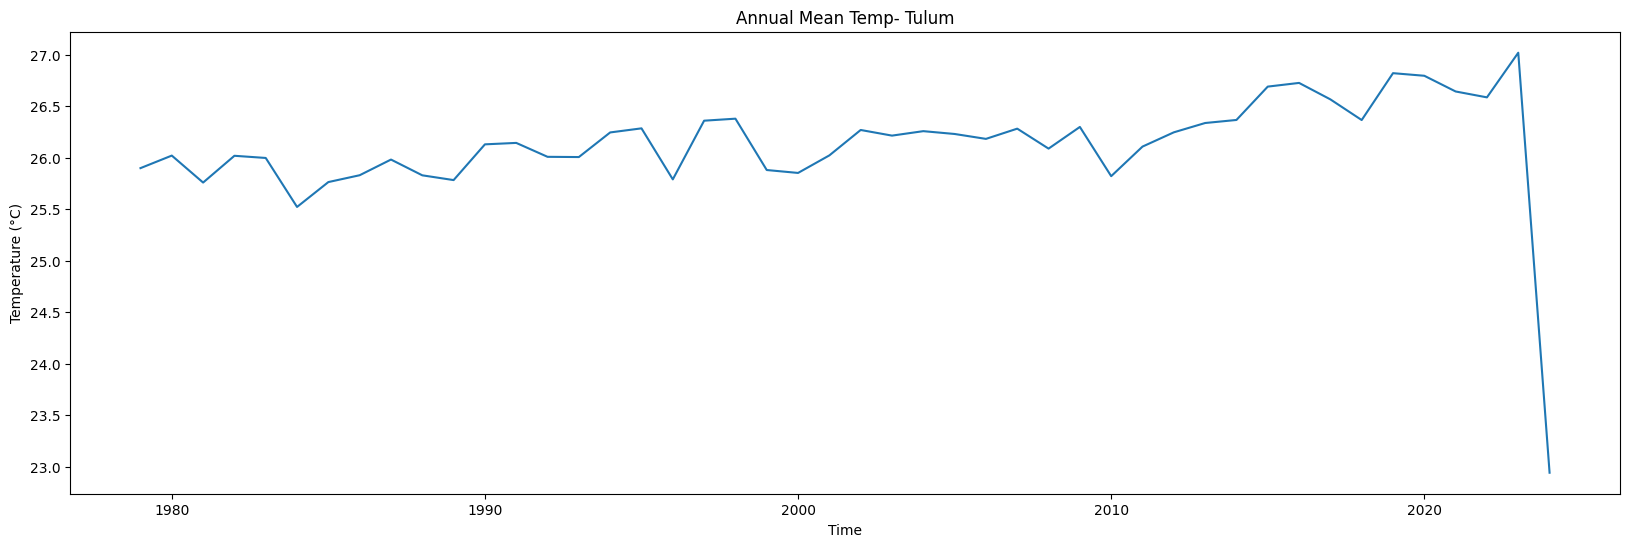

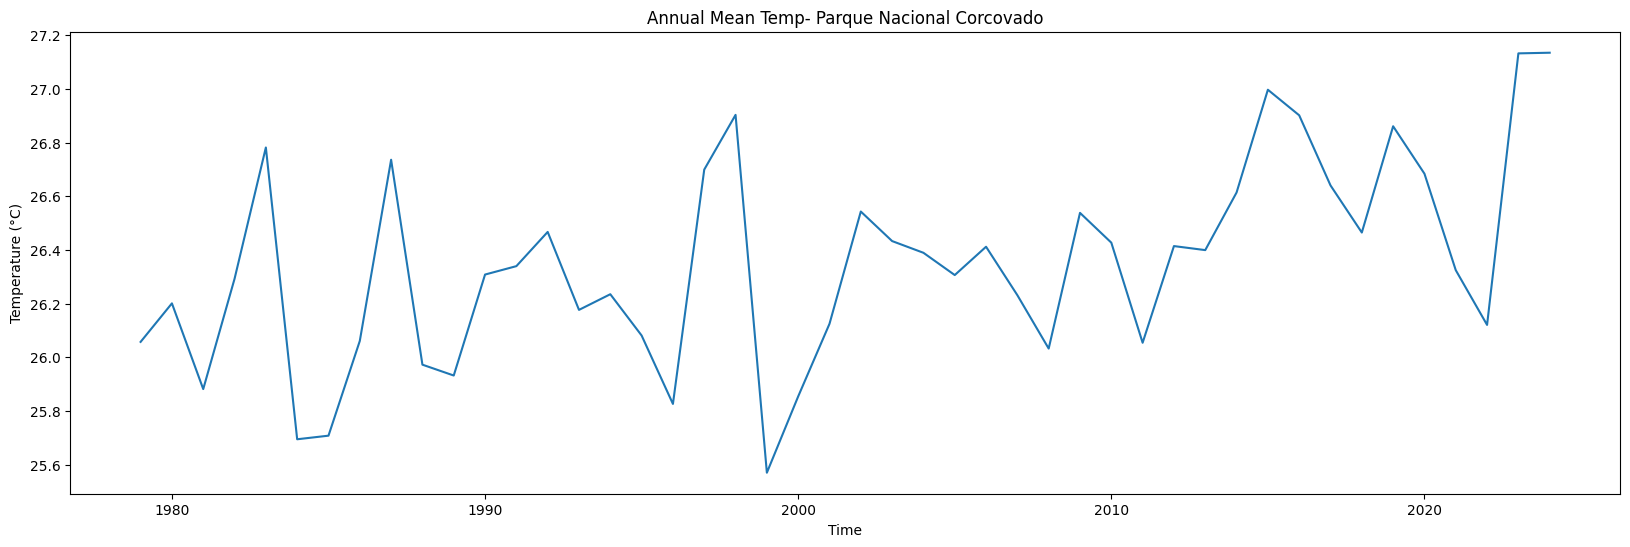

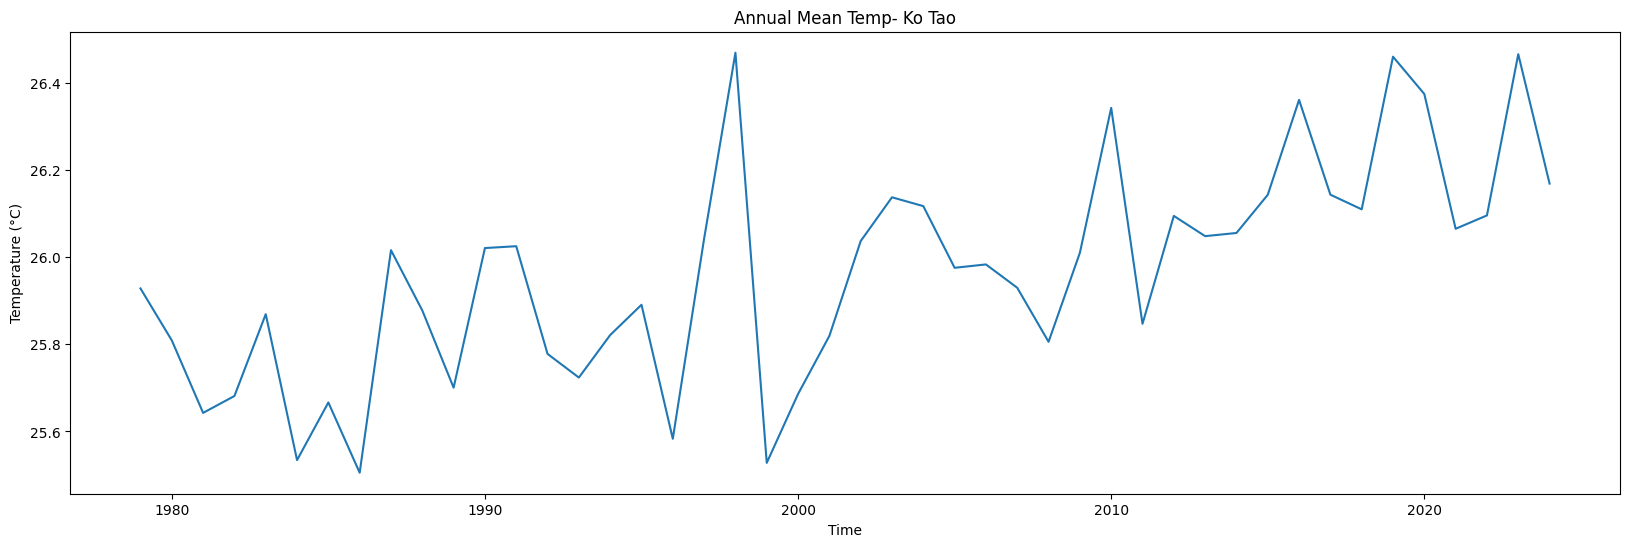

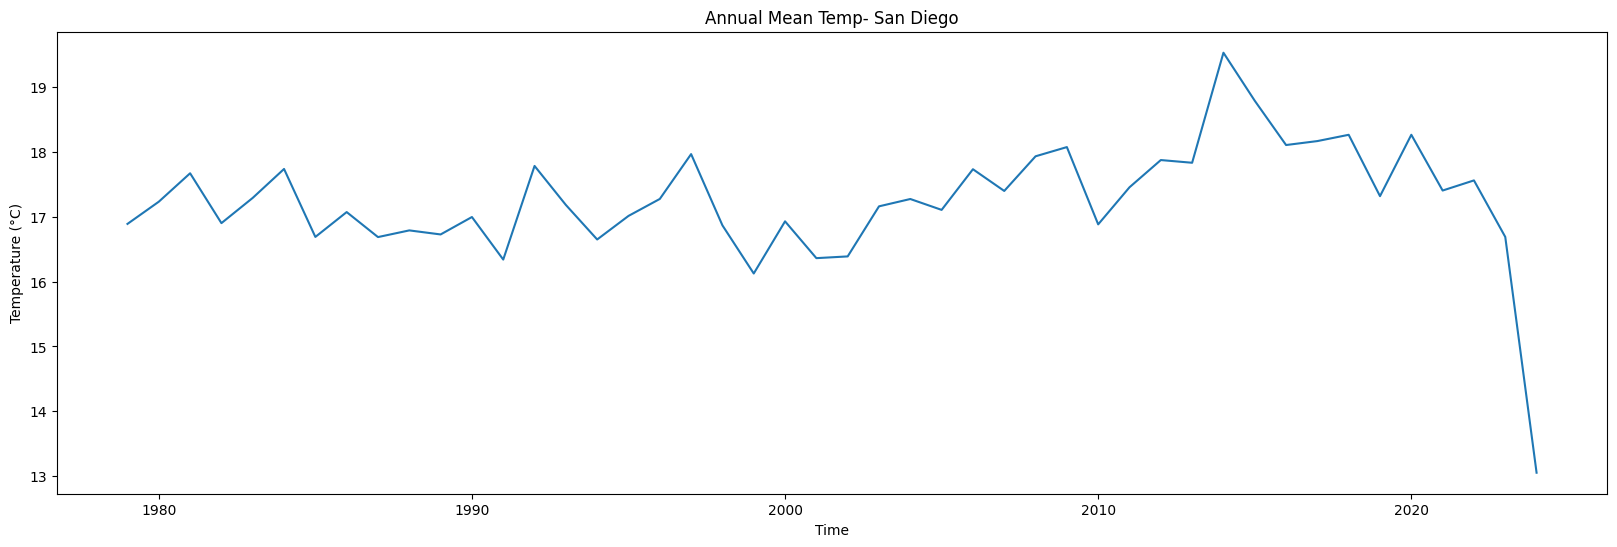

In [15]:
# Plots of annual mean temperatures
filtered_city_dfs = [filtered_weather_history_berlin, filtered_weather_history_tulum, filtered_weather_history_corcovado, filtered_weather_history_kotao, filtered_weather_history_sandiego]

def plot_medium_temp(df, city_name):
    df['main.temp'].groupby(df['Y']).mean().plot(figsize=(20, 6), title=f'Annual Mean Temp- {city_name}')
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C)')
    plt.show()

for city_name, df in zip(['Berlin', 'Tulum', 'Parque Nacional Corcovado', 'Ko Tao', 'San Diego'], filtered_city_dfs):
    plot_medium_temp(df, city_name)

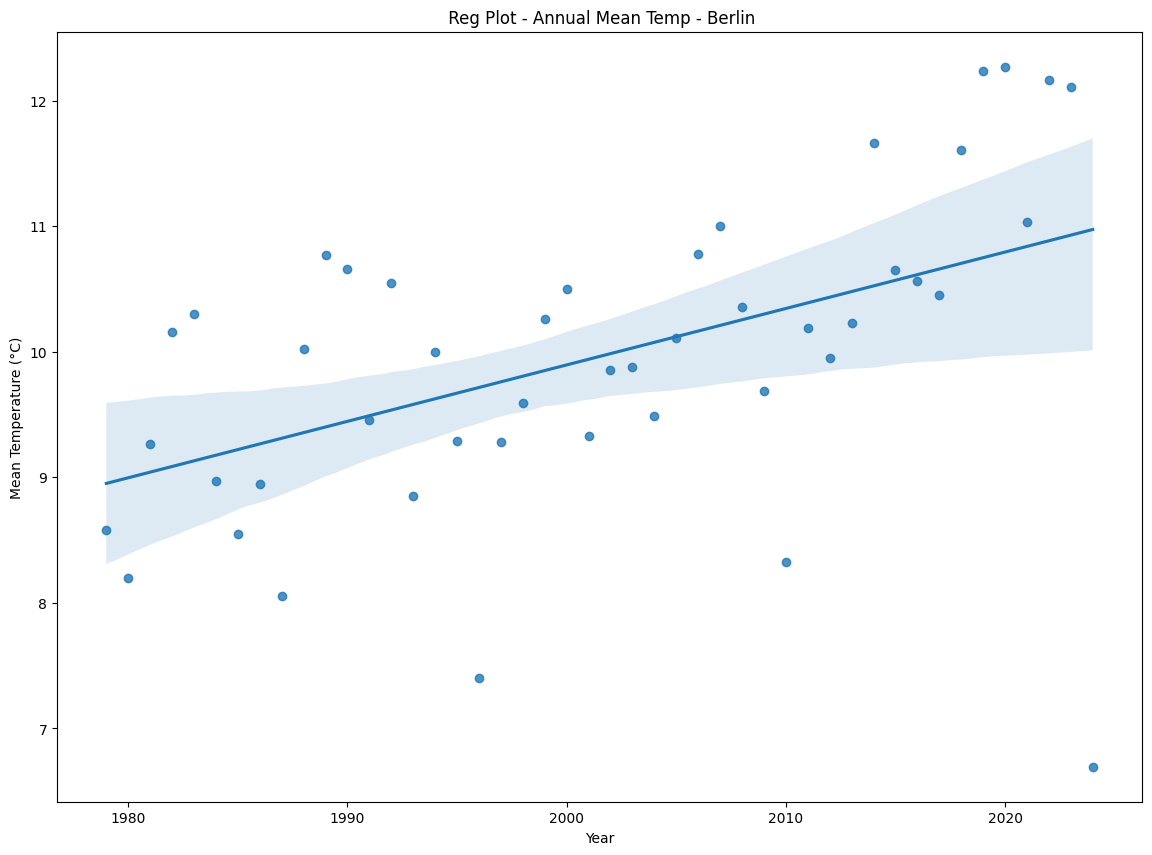

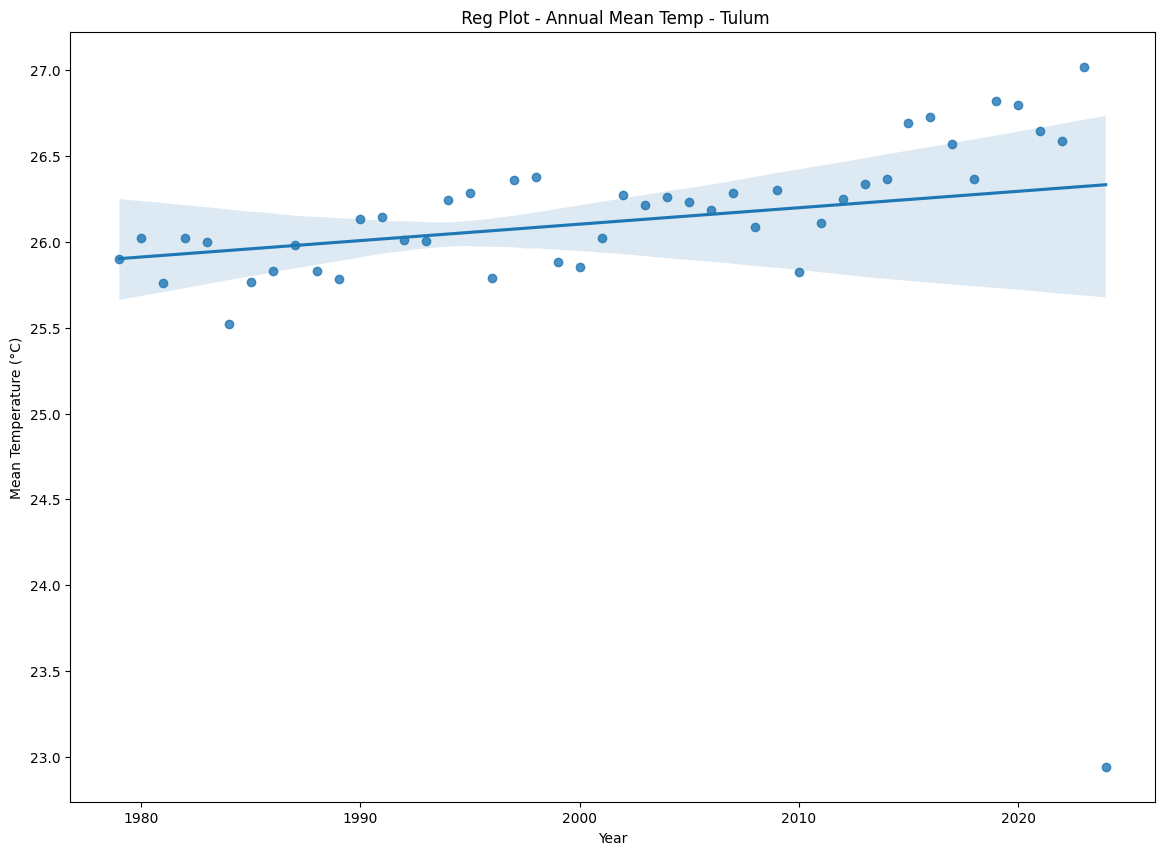

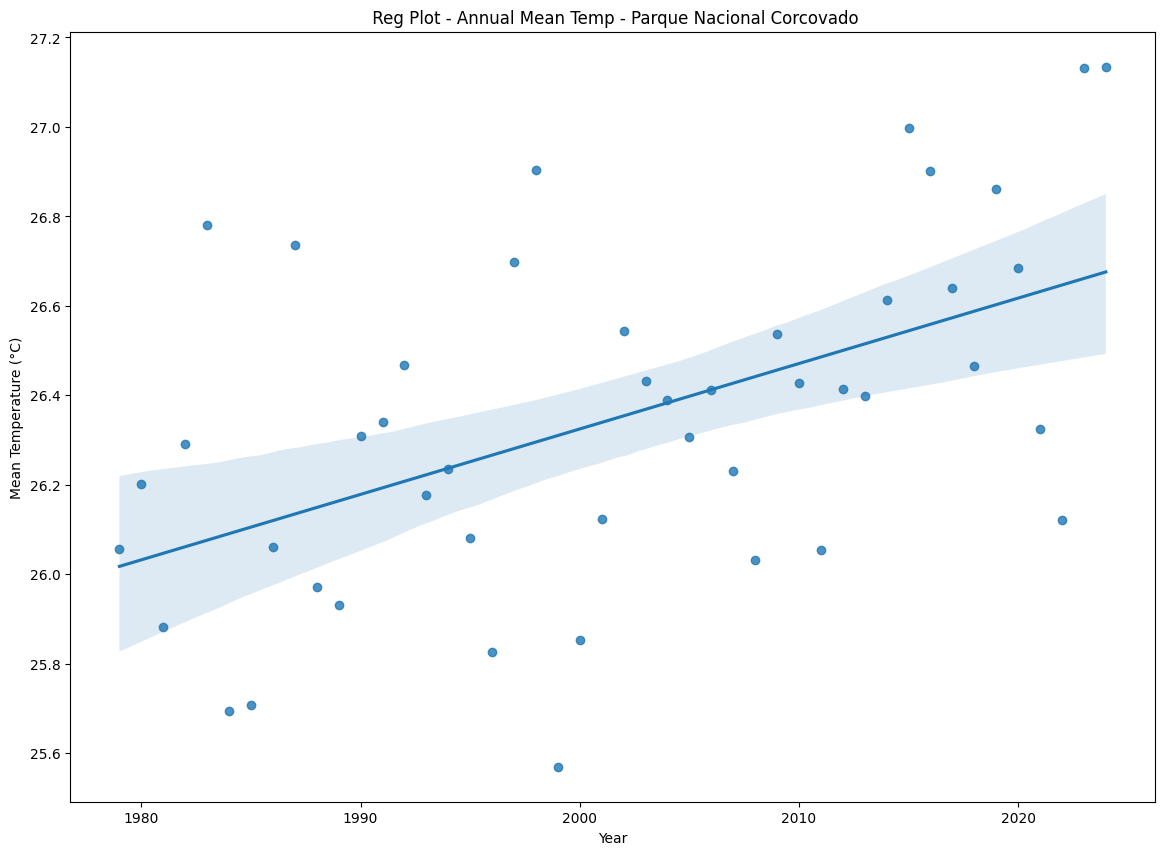

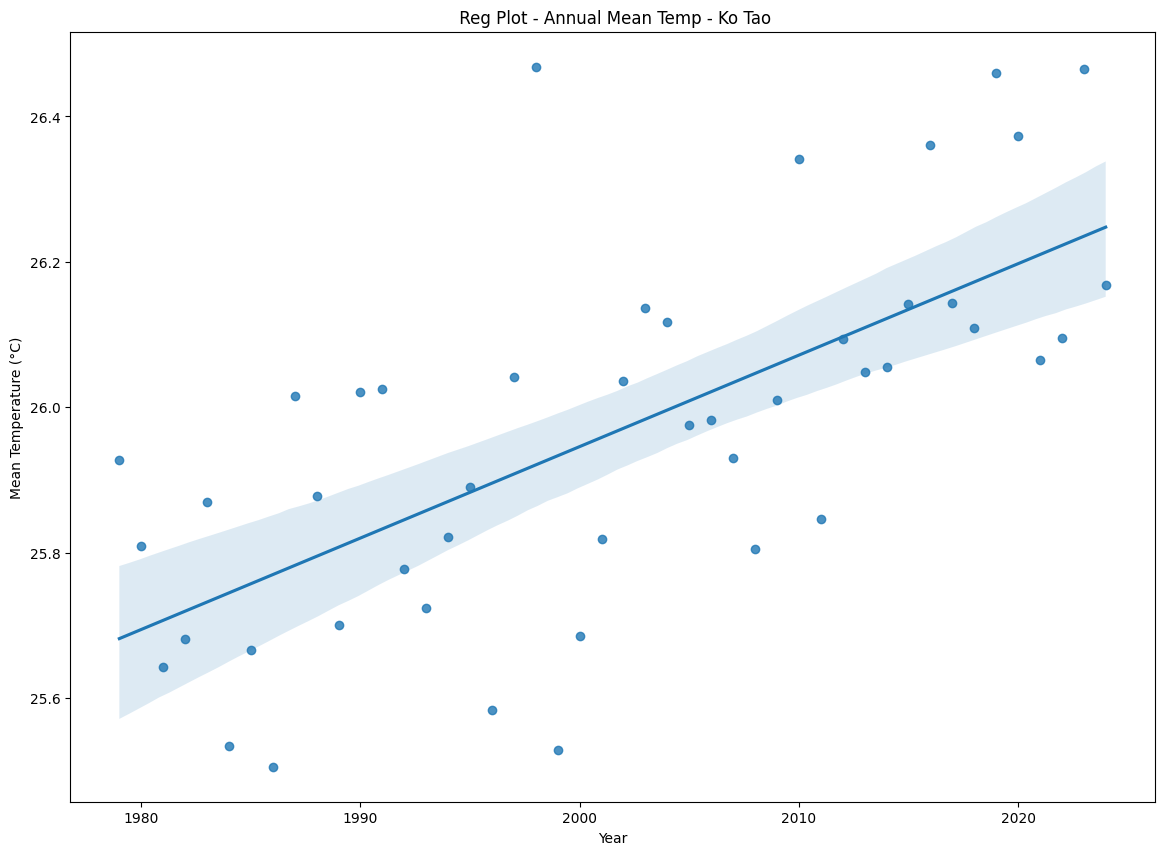

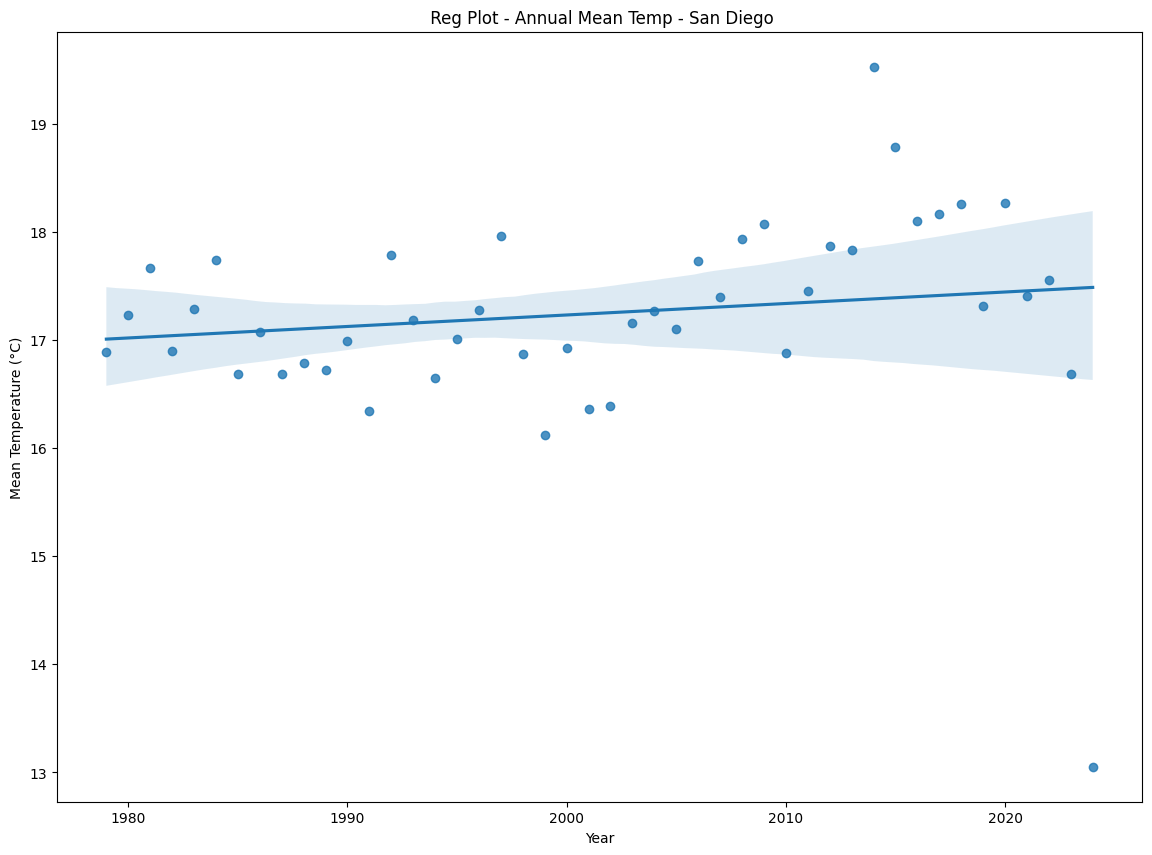

In [16]:
# Regression plots of annual mean temperatures
def regplot_temp(df, city_name):
    
    fig = sns.regplot(x=df['Y'].unique().astype(int), y=df['main.temp'].groupby(df['Y']).mean().astype(float))
    fig.figure.set_size_inches(14, 10)
    plt.xlabel("Year")
    plt.ylabel("Mean Temperature (°C)")
    plt.title(f' Reg Plot - Annual Mean Temp - {city_name}') 
    plt.show(fig)

for city_name, df in zip(['Berlin', 'Tulum', 'Parque Nacional Corcovado', 'Ko Tao', 'San Diego'], filtered_city_dfs):
    regplot_temp(df, city_name)

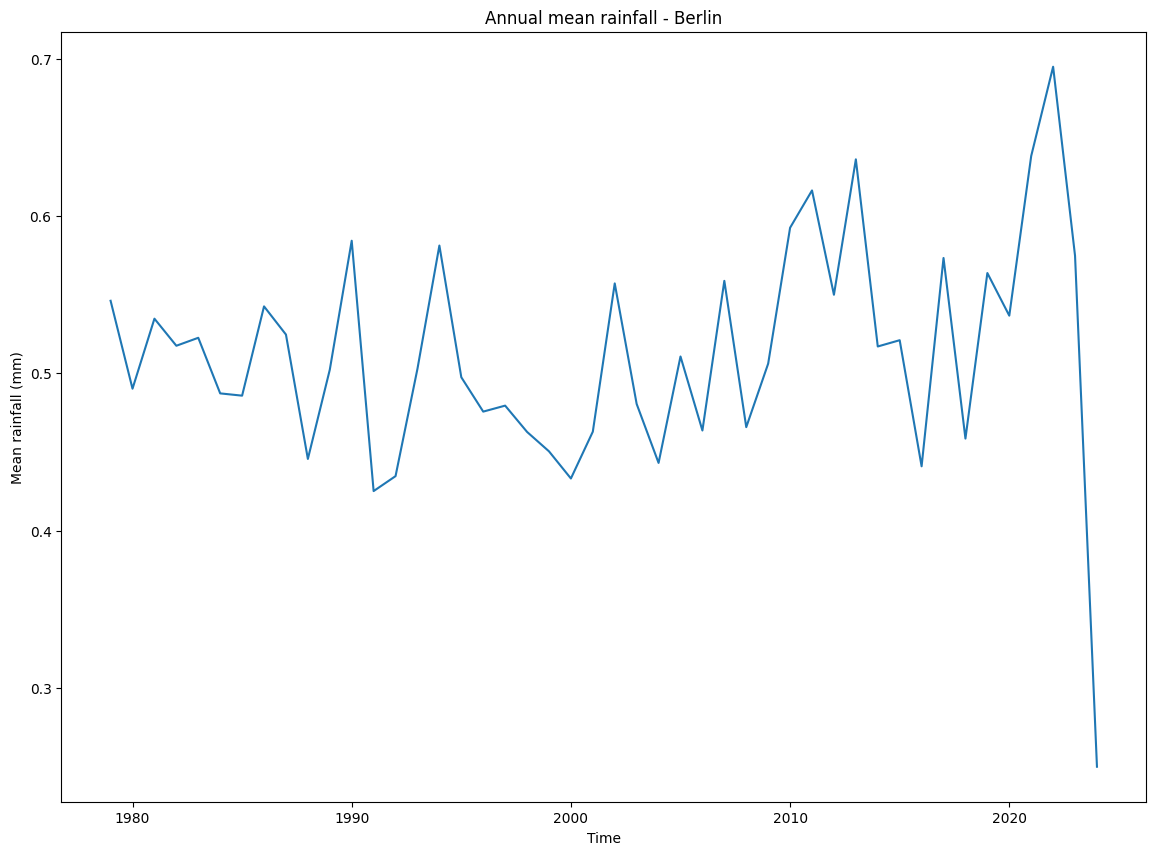

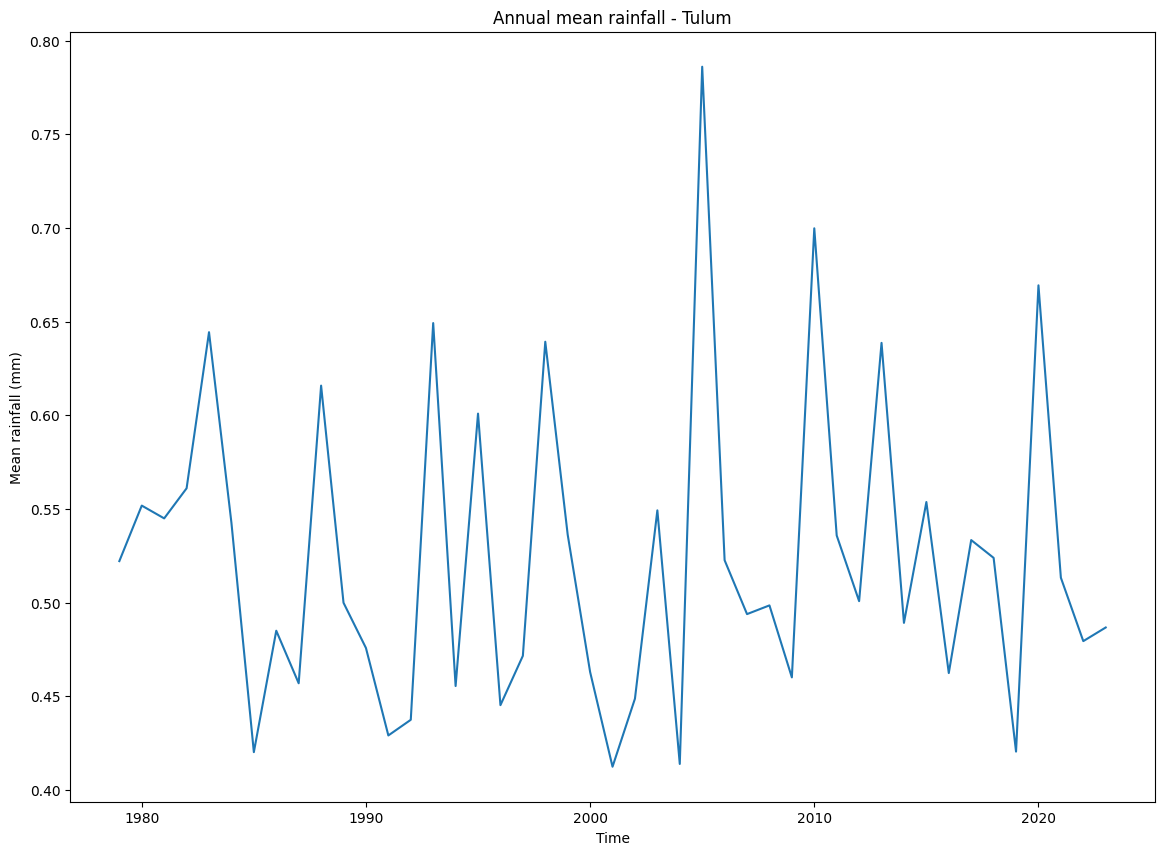

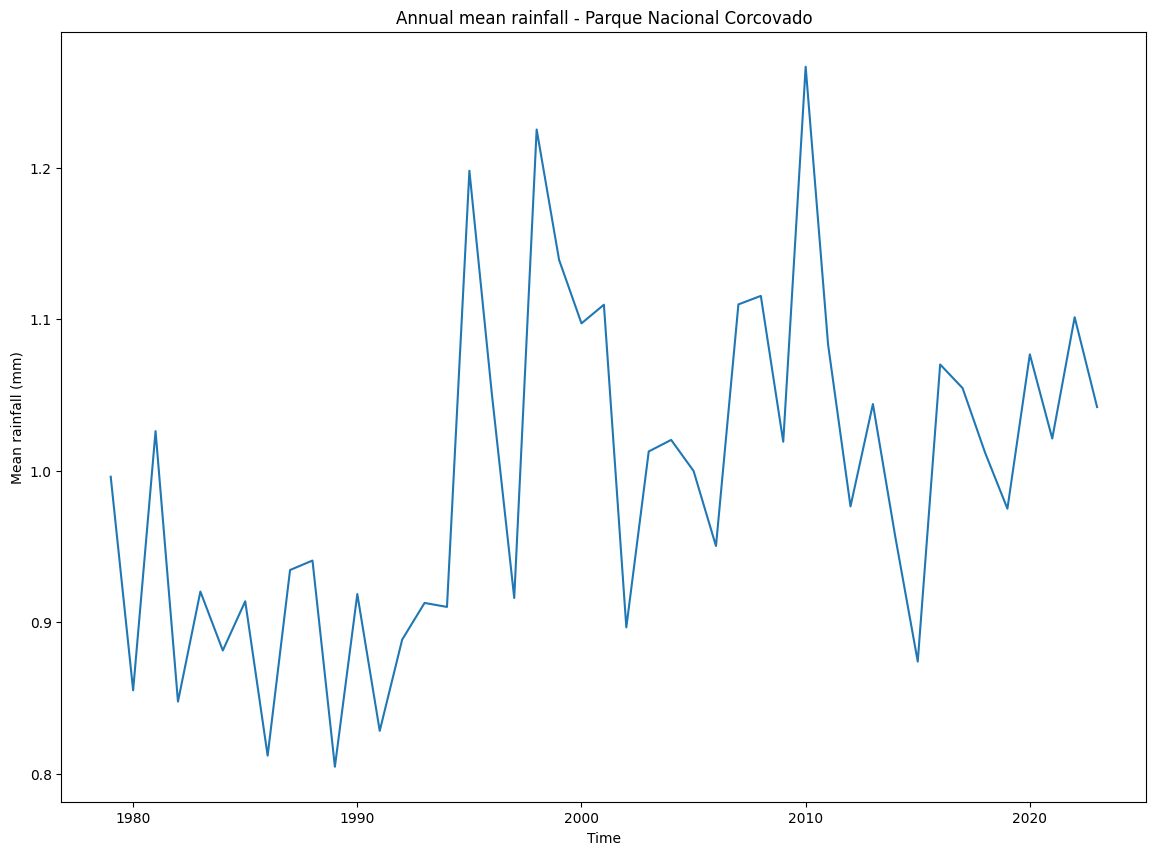

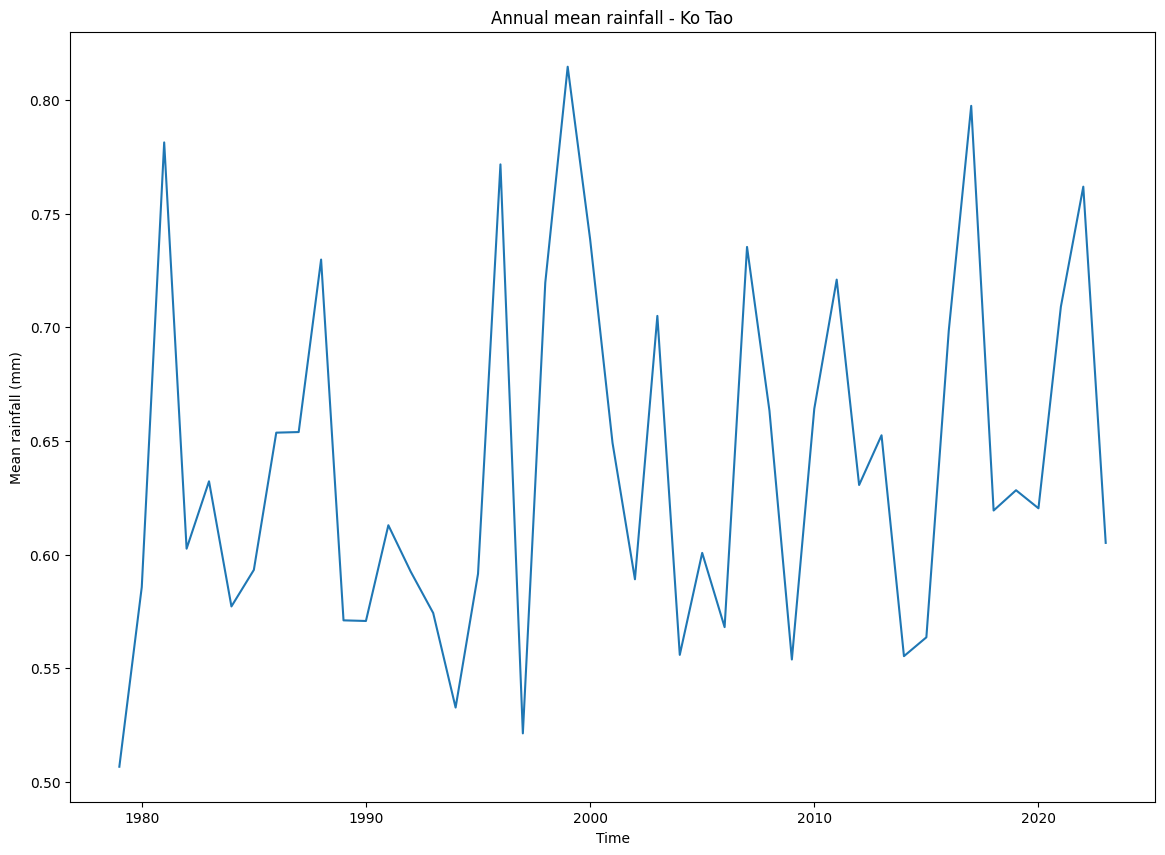

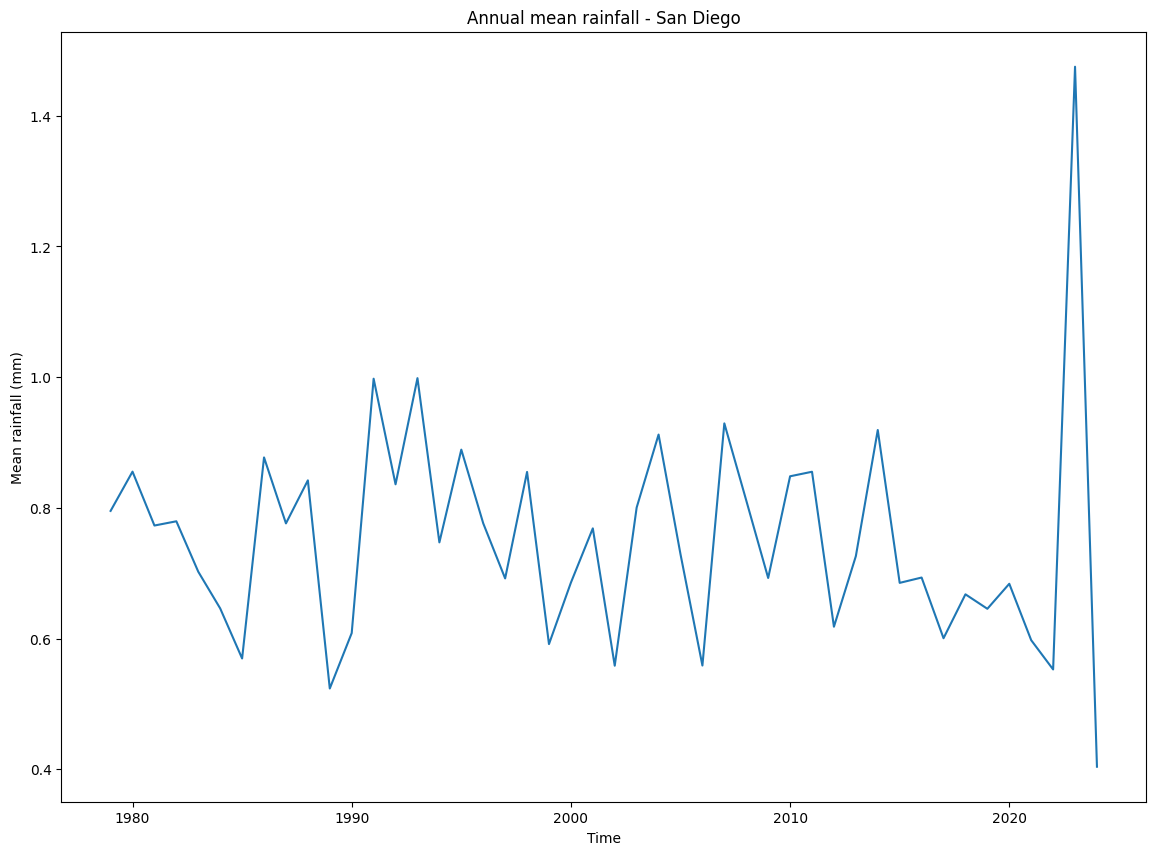

In [18]:
# Plots of annual mean rainfall
def plot_medium_temp(df, city_name):
    df['rain.1h'].groupby(df['Y']).mean().plot(figsize=(14, 10), title=f'Annual mean rainfall - {city_name}')
    plt.xlabel('Time')
    plt.ylabel('Mean rainfall (mm)')
    plt.show()

for city_name, df in zip(['Berlin', 'Tulum', 'Parque Nacional Corcovado', 'Ko Tao', 'San Diego'], filtered_city_dfs):
    plot_medium_temp(df, city_name)

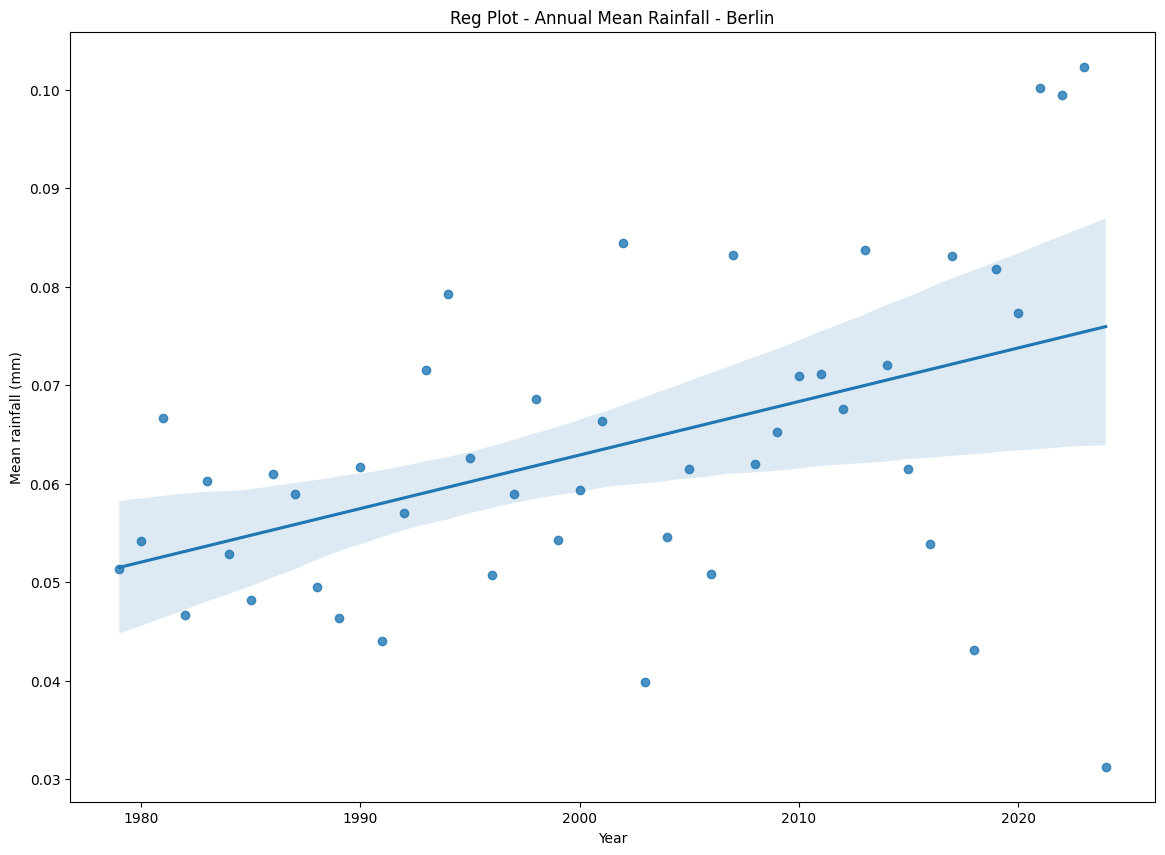

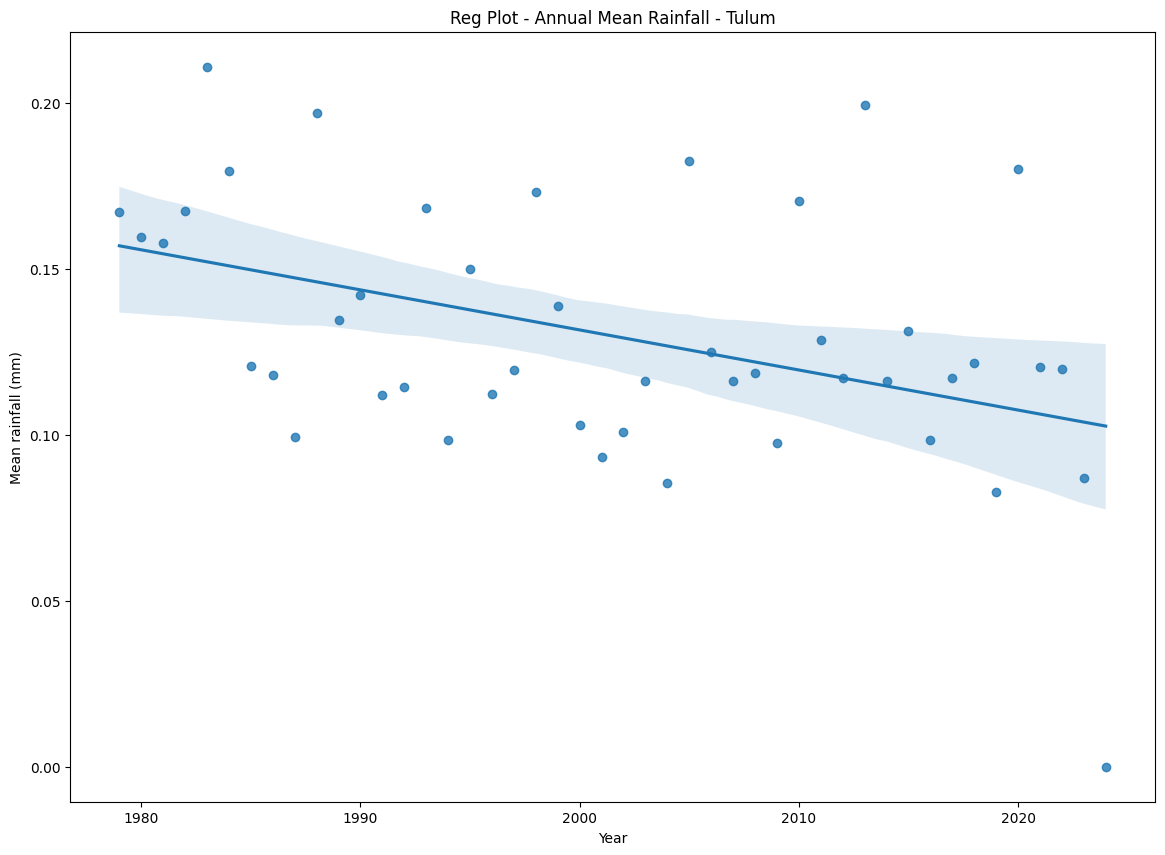

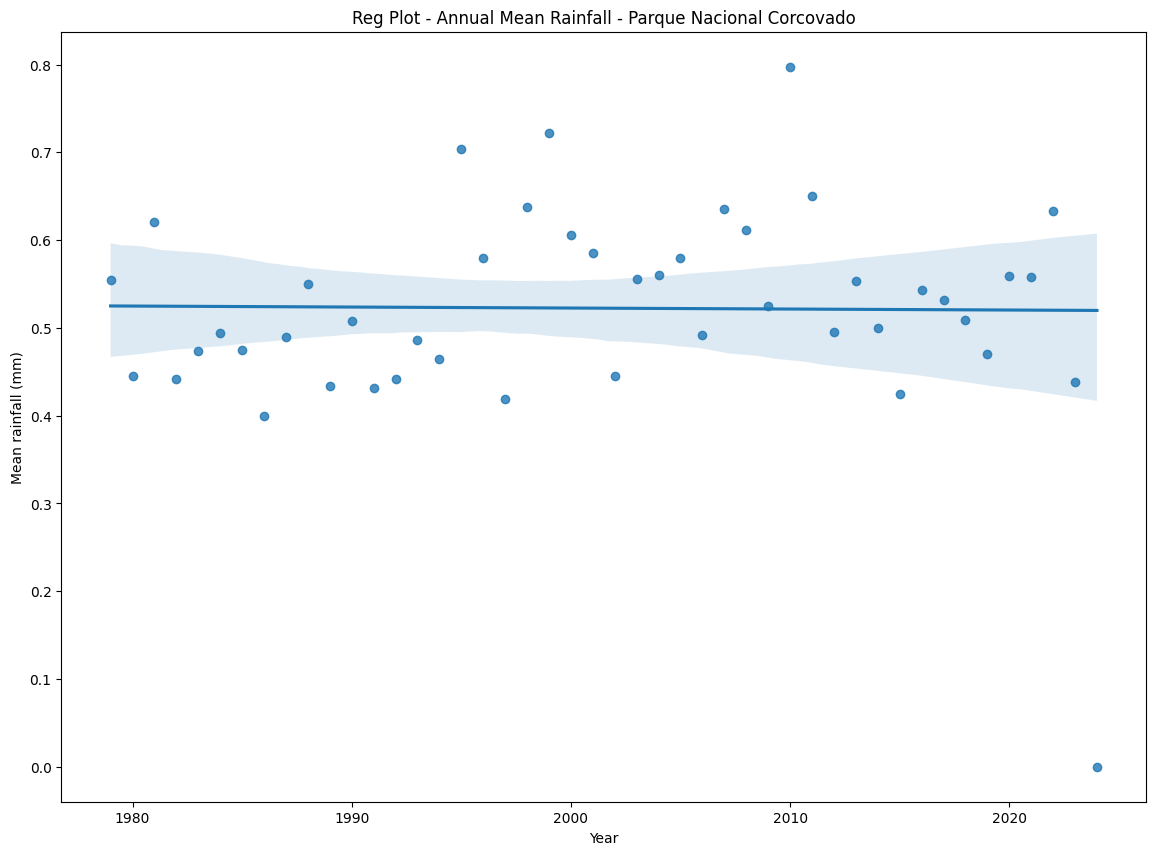

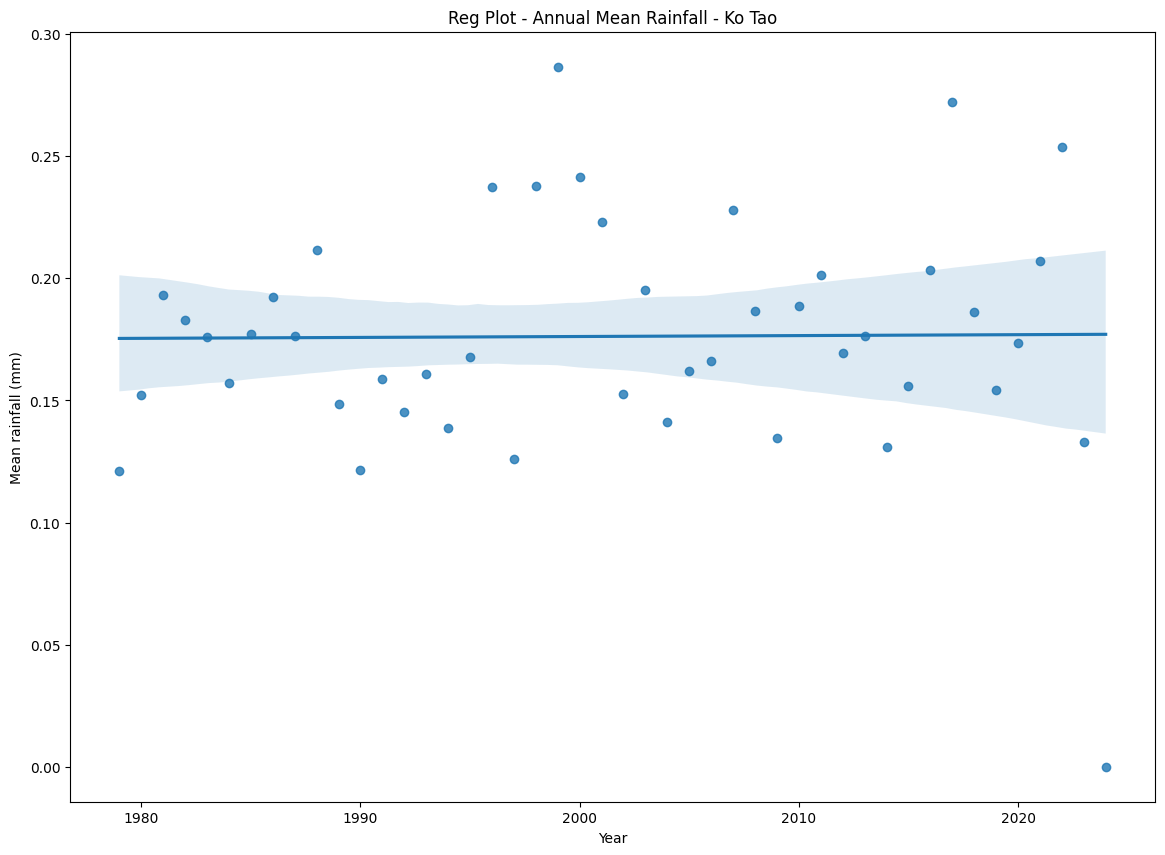

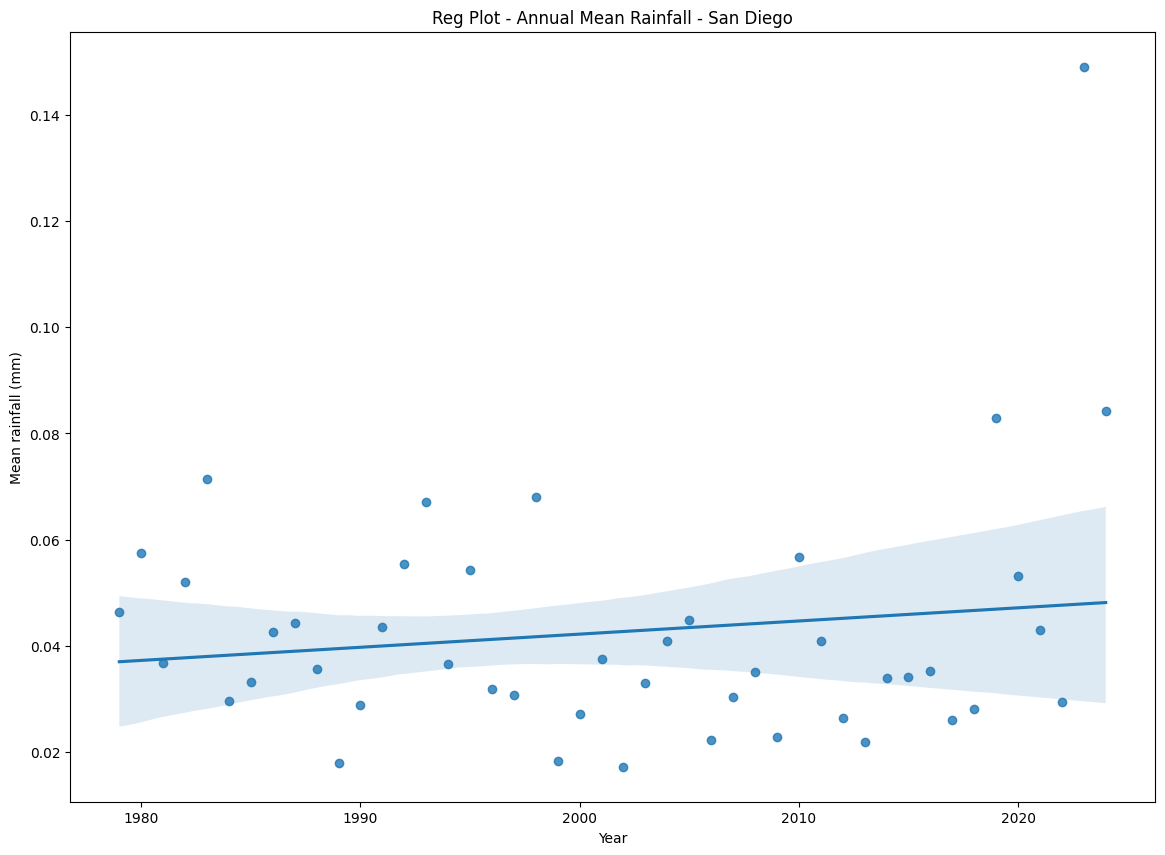

'filtered_city_dfs = [filtered_weather_history_berlin, filtered_weather_history_tulum, filtered_weather_history_corcovado, filtered_weather_history_kotao, filtered_weather_history_sandiego]\n\ndef regplot_temp(df, city_name, filename):\n    \n    fig = sns.regplot(x=df[\'Y\'].unique().astype(int), y=df[\'rain.1h\'].groupby(df[\'Y\']).mean().astype(float))\n    fig.figure.set_size_inches(14, 10)\n    plt.xlabel("Year")\n    plt.ylabel("Mean rainfall (mm)")\n    plt.title(f\' Reg Plot - Annual Mean Rainfall- {city_name}\') \n    plt.show(fig)\n\nfor city_name, df in zip([\'Berlin\', \'Tulum\', \'Parque Nacional Corcovado\', \'Ko Tao\', \'San Diego\'], filtered_city_dfs):\n    regplot_temp(df, city_name)'

In [77]:
def regplot_temp(df, city_name, filename):
    
    fig = sns.regplot(x=df['Y'].unique().astype(int), y=df['rain.1h'].groupby(df['Y']).mean().astype(float))
    fig.figure.set_size_inches(14, 10)
    plt.xlabel("Year")
    plt.ylabel("Mean rainfall (mm)")
    plt.title(f' Reg Plot - Annual Mean Rainfall- {city_name}') 
    plt.show(fig)

for city_name, df in zip(['Berlin', 'Tulum', 'Parque Nacional Corcovado', 'Ko Tao', 'San Diego'], filtered_city_dfs):
    regplot_temp(df, city_name)

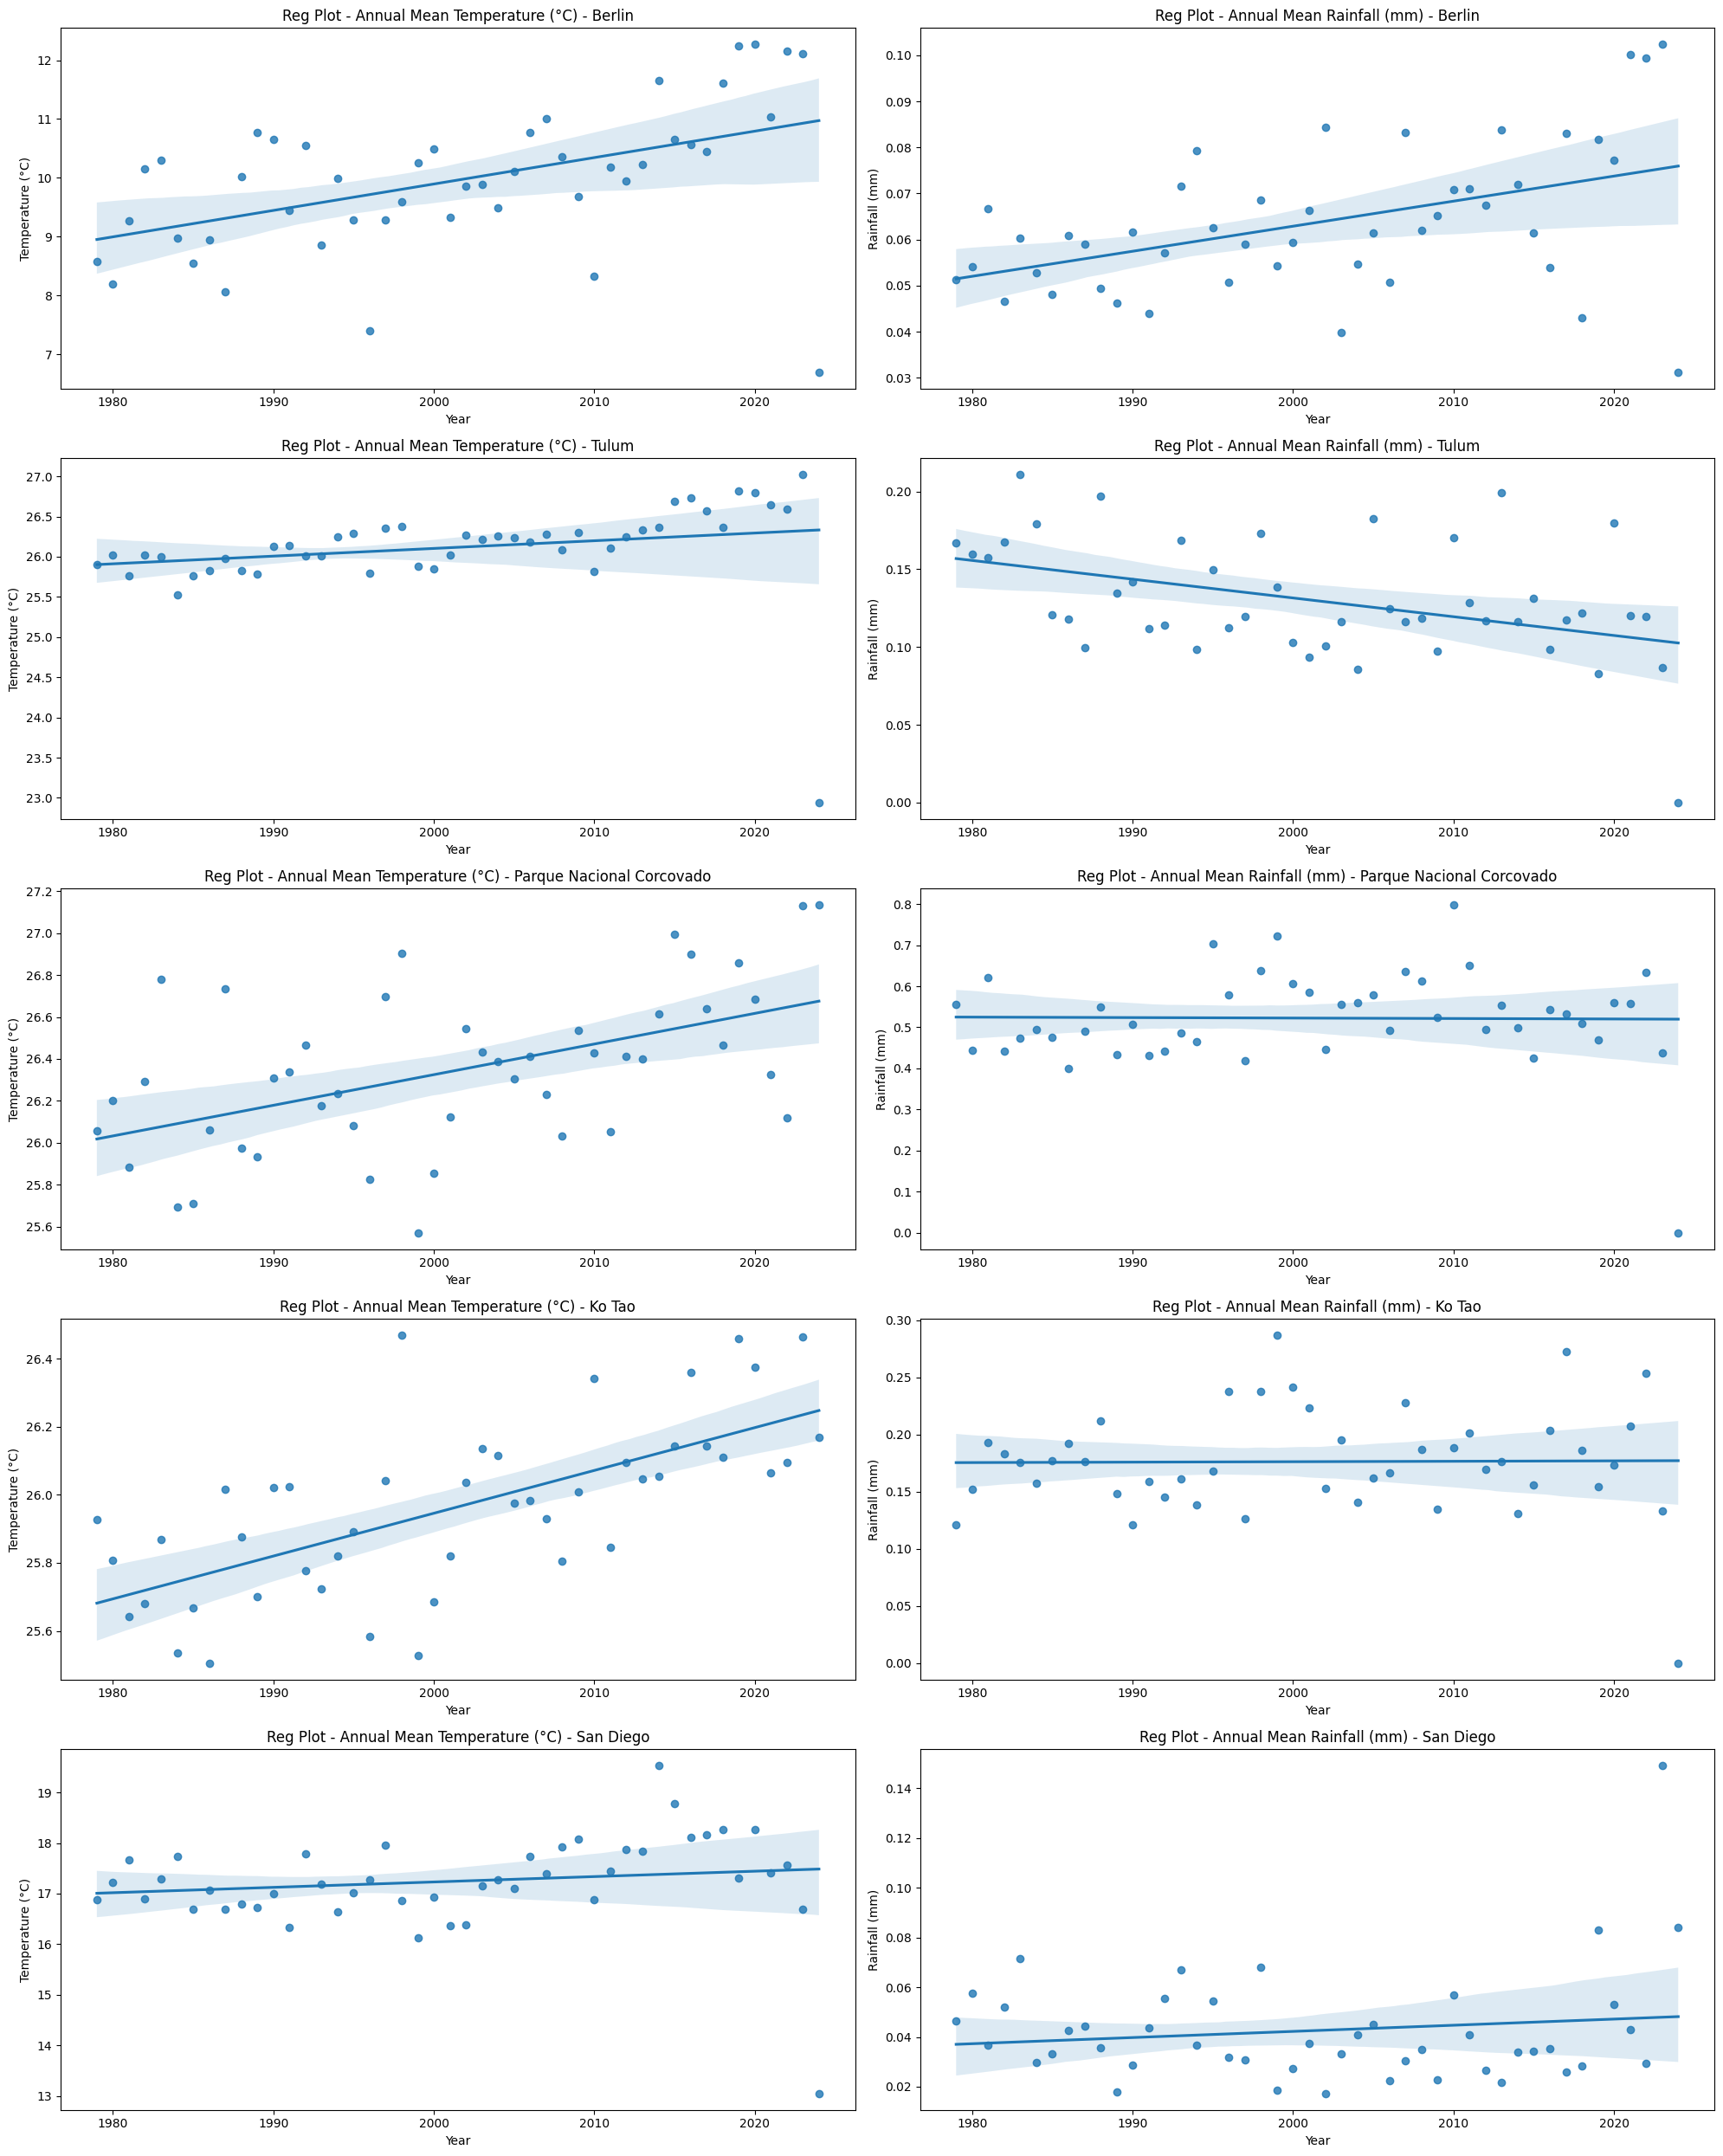

In [85]:
# Plot all combined regression plots for mean annual temperature and rainfall
def regplot_comb(df, city_name, ax, variable, ylabel):
    sns.regplot(x=df['Y'].unique().astype(int), y=df[variable].groupby(df['Y']).mean().astype(float), ax=ax)
    ax.set_xlabel("Year")
    ax.set_ylabel(ylabel)
    ax.set_title(f'Reg Plot - Annual Mean {ylabel} - {city_name}')

# Create a 5x2 subplots grid
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 25))

# Plot mean annual temperature data on the left side
for i, (city_name, df) in enumerate(zip(['Berlin', 'Tulum', 'Parque Nacional Corcovado', 'Ko Tao', 'San Diego'], filtered_city_dfs)):
    regplot_comb(df, city_name, axes[i, 0], 'main.temp', 'Temperature (°C)')

# Plot mean annual rainfall data on the right side
for i, (city_name, df) in enumerate(zip(['Berlin', 'Tulum', 'Parque Nacional Corcovado', 'Ko Tao', 'San Diego'], filtered_city_dfs)):
    regplot_comb(df, city_name, axes[i, 1], 'rain.1h', 'Rainfall (mm)')

# Show the plot
plt.tight_layout()
plt.show()

In [76]:
# Save filtered dataframes as CSV, compress it, upload it to AWS S3
city_names = ["berlin", "tulum", "corcovado", "kotao", "sandiego"]

def filtered_df_to_CSV_push_to_S3(filtered_weather_history_dfs, city_name):
    client = boto3.client(
        's3',
        aws_access_key_id = aws_access_key,
        aws_secret_access_key = aws_secret_key,
        region_name = 'us-east-1'
    )

    compressed = dict(method='zip', archive_name=f"{city_name}_weather_history.csv")  
    filtered_weather_history_dfs.to_csv(path_or_buf=f"{my_path}/{city_name}_weather_history.zip", index=False, compression=compressed)
    client.upload_file(my_path+"/"+f"{city_name}_weather_history.zip", 'weather-data-history', f"{city_name}_weather_history.zip")

    return "Done."
    
for city_df, city_name in zip(filtered_city_dfs, city_names):
    filtered_df_to_CSV_push_to_S3(city_df, city_name)

'\n    # Export the price history dataframe to a zipped CSV file then push to AWS S3.\n    compression_opts = dict(method=\'zip\', archive_name=\'df_full_price_history_complete_load.csv\') \n    df_price_history_complete_load.to_csv(path_or_buf = my_path + "/df_full_price_history_complete_load.zip", index=False, compression=compression_opts)\n    client.upload_file(my_path + "/df_full_price_history_complete_load.zip", \'bns-intrinio-data\', "price-data-historical/csv_files/df_full_price_history_complete_load.zip")\n'